In [16]:
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1.axes_rgb import RGBAxes
import numpy as np
import xarray as xr
from os.path import join
import reader
import pandas as pd
import numpy.linalg as linalg
from scipy.stats import chi2
import warnings
import itertools
import cv2

warnings.simplefilter("ignore") 

### Read the data

In [17]:
fname = "data/covariance_matrix/CovMat.mat"
ds = reader.read_covar_matrix(fname)
ds = ds.load()
#ds.imag.to_netcdf('data/netcdf/CovMatImag.nc')

### Plot of the covariance matrices

Histograms of pixel power for each element in one of the covariance matrices, $\langle C_{i,j} 
\rangle$, to check that they are as expected

Histograms of each element in fl063_l


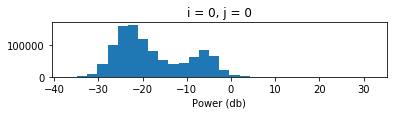

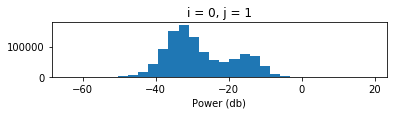

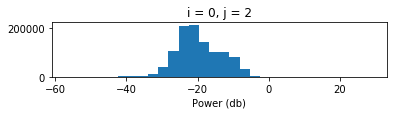

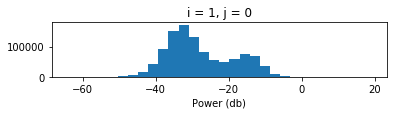

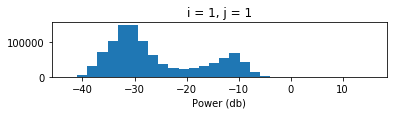

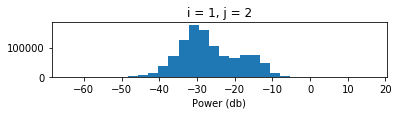

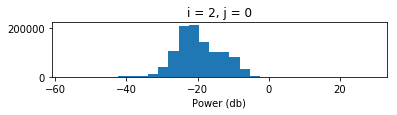

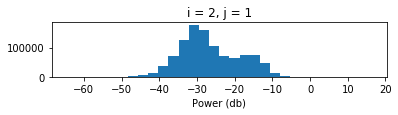

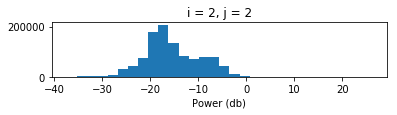

In [13]:
cm = 'fl063_l'
print(f"Histograms of each element in {cm}")
ijs = itertools.product(ds.i.values, ds.j.values)
for i, j in ijs:
    plt.figure(figsize=(6,1))
    (10*np.log10(ds[cm].sel(i=i, j=j))).plot.hist(bins=30)
    plt.xlabel('Power (db)')
    plt.title(f'i = {i}, j = {j}')
    plt.show()

## Plot the field mask

The masks are used to select fields and forest areas.

The mask labels are as follows:

1	Rye <br>
2	Grass (Rajgræs)<br>
3	Winter wheat<br>
4	Grass (Rajgræs)<br>
5	Winter wheat<br>
6	Spring barley<br>
7	Peas<br>
8	Rye<br>
9	Spring oats<br>
10	Grass (Rajgræs)<br>
11	Winter wheat<br>
12	Rye<br>
13	Spring barley<br>
14	Spring barley<br>
15	Peas<br>
16	Grass (Rajgræs)<br>
17	Winter barley<br>
18	Peas<br>
19	Peas<br>
20	Winter wheat<br>
21	Peas<br>
22	Winter wheat<br>
23	Rye<br>
24	Peas<br>
25	Winter barley<br>
26	Grass (Rajgræs)<br>
27	Winter wheat<br>
28	Peas<br>
29	Spring barley<br>
30	Beets<br>
31	Spring barley<br>
32	Grass (slet græs)<br>
33	Winter wheat<br>
34	Spring barley<br>
35	Winter wheat<br>
36	Spring barley<br>
37	Peas<br>

101 Lake<br>

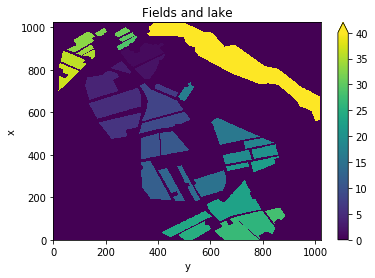

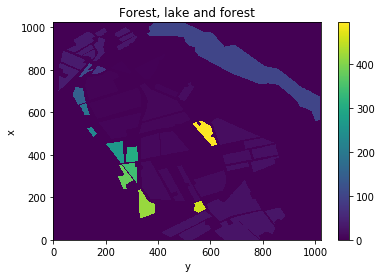

In [41]:
mask = xr.open_rasterio('data/masks/mask_fields.tif').squeeze()
mask = xr.DataArray(mask.values, dims=('x', 'y'))
np.flip(mask, axis=0).plot(vmax=40);
plt.title("Fields and lake")
plt.show()

vals = np.nan_to_num(xr.open_dataset('data/masks/mask_forest.nc').Band1.values).astype(np.int)
mask_forest = xr.DataArray(np.flipud(vals), dims=('x', 'y'))
#import scipy.io as sio
#sio.savemat('data/masks/foulum_field_mask.mat', {'fields': mask.values})
#np.flip(mask_forest, axis=0).plot();
#plt.title("Forest")
#plt.show()

mask_all = mask + mask_forest*38
np.flip(mask_all, axis=0).plot();
plt.title("Forest, lake and forest");

### RGB plots of the diagonals

fl063_c


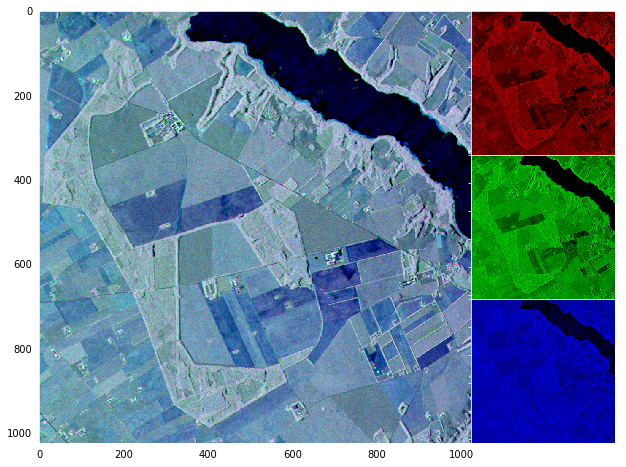

fl063_l


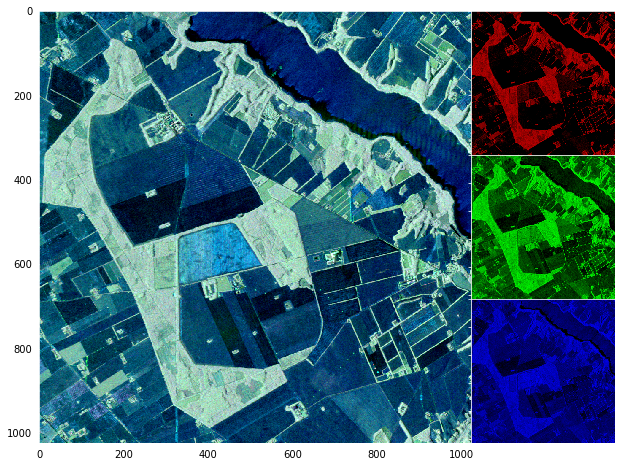

fl064_c


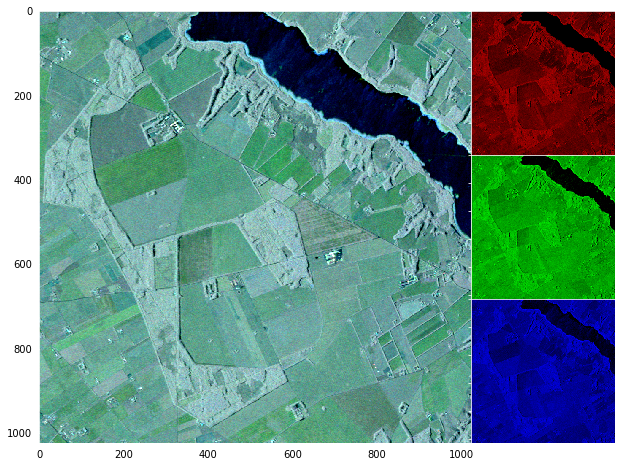

fl064_l


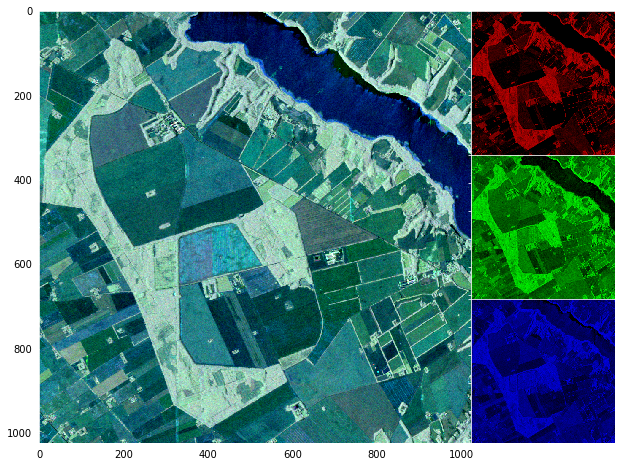

fl065_c


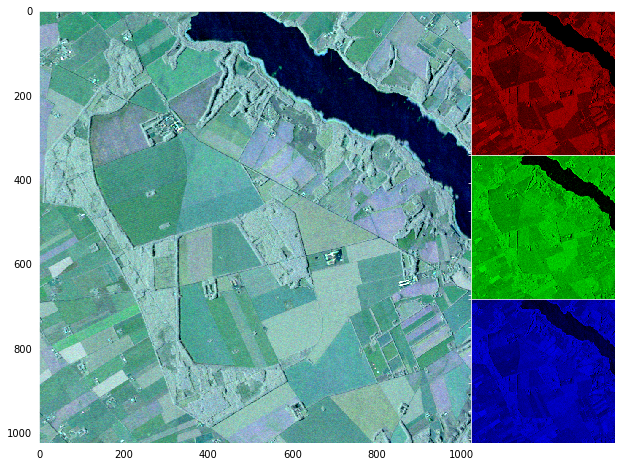

fl065_l


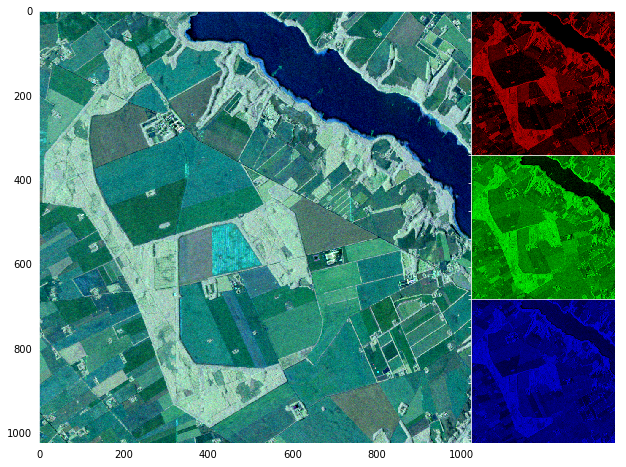

fl068_c


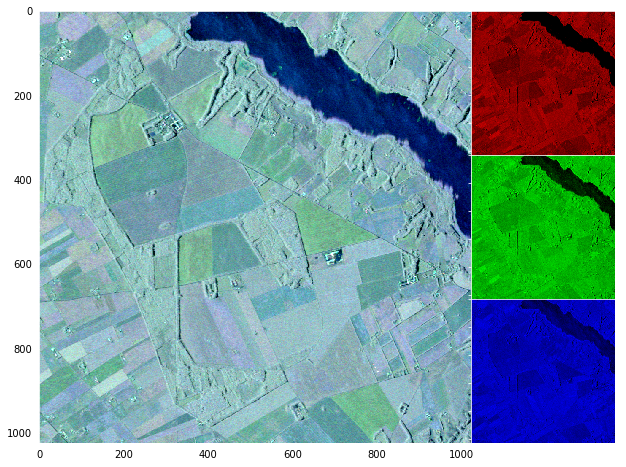

fl068_l


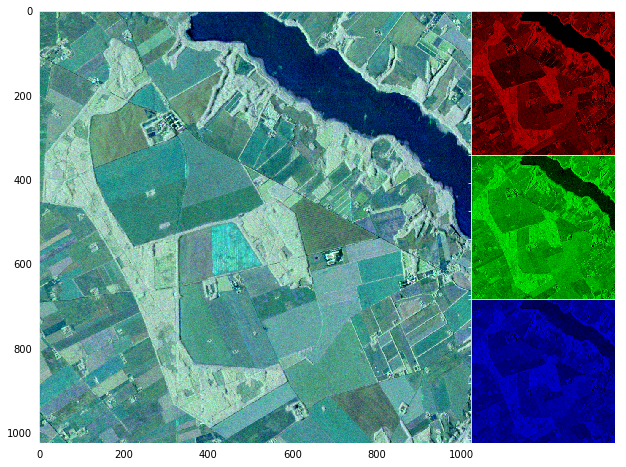

In [6]:
def normalise(c):
    c = c.real
    c = np.clip(c, 0.001, 1)
    c = (3 + np.log10(c))/3 
    return c 

for v in list(ds.variables):
    da = ds[v]
    rgb = [da.isel(i=i,j=j) for i, j in [(1 ,1), (0, 0), (2, 2)]]
    rgb = [normalise(c) for i, c in enumerate(rgb)]
    
    fig = plt.figure(figsize=(10, 10))
    ax = RGBAxes(fig, [0.1, 0.1, 0.8, 0.8])
    print(v)
    ax.imshow_rgb(*rgb)
    plt.show()
    #fname = join('/data/jol/sat_data/sar_polar/plots', v + '.png')
    #fig.savefig(fname, tightlayout=True)

## Caculate the ENLs

The Equivalent Number of Looks (ENL) is given by:

$\text{ENL} = \frac{E^2}{\sigma^2}$

For each covariance matrix, the ENLs are computed for element and each field and plotted in a histogram

The C band has values up to about 14, and the L values are up to about 11. These upper values are choosen as the ENLs for calculating the Q statistics.

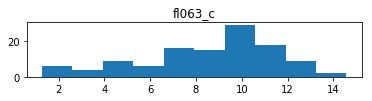

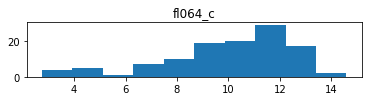

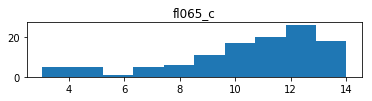

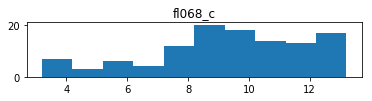

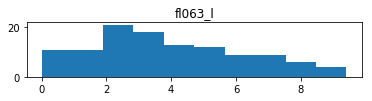

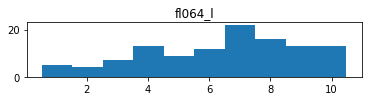

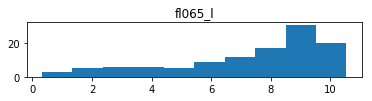

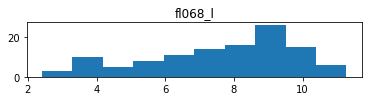

In [36]:
diag_els = [(0, 0), (1, 1), (2, 2)]
all_els =[(i, j) for i in range(3) for j in range(3)]
def ENLs(CVMs, field, mask, k):
    for i, j in diag_els:
        ss = np.abs(CVMs[k].where(mask==field).sel(i=i, j=j))        
        E = ss.mean()
        Var = ss.std()**2
        yield k, field, f"{i}{j}", float(E**2/Var)

def get_enls(CVMs, mask):
    for cov_matrix in CVMs.variables.keys():
        for field in range(1, 39):
            yield from ENLs(CVMs, field, mask, cov_matrix)
            
def plot_ENLs(ds, mask):
    enl_df = pd.DataFrame(list(get_enls(ds, mask)), columns=['cvm', 'field', 'ij', 'enls'])
    enl_df = enl_df.sort_values(by=['cvm', 'field'])
    
    cvms = sorted(list(enl_df.cvm.unique()), key=lambda x: x[-1])
    for cvm in cvms:
        enls_cvm = enl_df[enl_df.cvm==cvm].pivot_table(index='field', columns='ij')
        enls_cvm['max'] = enls_cvm.apply(np.max, axis=1)
        enls_cvm.sort_values('max', inplace=True, ascending=False)
        plt.figure(figsize=(6,1))
        plt.hist(enls_cvm['enls'].values.flatten())
        plt.title(cvm)
        #plt.xlim(0, 15)
        plt.show()
        #print(enls_cvm.head(10))
        
plot_ENLs(ds, mask_all)

### Compute the Q statistics

Given two covariance matrices that we want to compare, $X$ and $Y$, the Q statistics (used to compare with the theoretical) is given by:
$$
P_{estimated} = -2 \rho \ln Q,$$
where
$$Q = n (2 p \ln(2) + \ln(|X|) + \ln(|Y|) - 2 \ln(|X + Y|))$$
and
$$\rho(p, m, n) = 1 - \frac{2 p^2 - 1}{6 p}  \left(\frac{1}{n} + \frac{1}{m} - \frac{1}{n + m}\right)$$

The theoretical distrubtions is given by
$$P_{theoretical} = \chi^2(p^2)$$

For a homogeneous region
$$P_{estimated} \approx P_{theoretical}$$

In [48]:
# Some of the functions here are reduntant as other functions are used instead.
# but they are kept to verify that the alternative functions are correct.

def rho_i(p, m, n):
    return 1 - ((2*p**2 - 1)/(6*p)) * (1/n + 1/m - 1/(n + m))

def rho_azimuthal(p, m, n):
    """
    Defines ρ azimuthal. However, this function is not used, because ρ reduces to
    rho_i(p, m, n)
    """
    p1, p2 = 2, 1
    return (1/p**2) * (p1**2 * rho_i(p1, m, n) + p2**2 * rho_i(p2, m, n))

def rho_symetric(p, m, n):
    return rho_i(p, m, n)

# Used to select ρ. However, we use the same ρ all symetry cases  
rho = dict(full=rho_i, azimuthal=rho_i, symetric=rho_i)
# Used to select the p, which depends on the symetry 
ps = dict(full=3, symetric=np.sqrt(3), azimuthal=np.sqrt(5))

def omega(p, m, n, symmetry):
    return (-p**2 / 4) * (1 - 1/rho[symmetry](p, n, m))**2 +\
    ((p**2 * (p**2 -1))/24) *\
    (1/n**2 + 1/m**2 - 1/(n + m)**2) * (1/rho[symmetry](p, n, m)**2) 

def det(A):
    """
    Not used in here, as logdet(A) is used instead
    """
    return linalg.det(A.transpose('x', 'y', 'i', 'j'))

def logdet(A):
    """
    input A: covariance matrix
    returns: ln(|A|)
    slogdet calculates ln(|A|) is one go, and handle large array better
    that np.log(np.det(A))
    """
    sign, val = np.linalg.slogdet(A.transpose('x', 'y', 'i', 'j'))
    return val

def get_X(Sx, symmetry):
    """
    Get the covariance matrices, setting the some of the elements to zero,
    depending on the symetry.
    """
    Sx = Sx.copy()
    if symmetry == 'full':
        set0 = np.ones_like(Sx)
    if symmetry == 'symetric':
        set0 = np.zeros_like(Sx)
        set0[0, 0,:,:] = set0[1, 1, :, :] = set0[2 ,2 ,: ,: ] = np.ones((1024, 1024))
    elif symmetry == 'azimuthal':
        set0 = np.ones_like(Sx)
        set0[0, 1,:,:] = set0[1, 0, :, :] = set0[1 ,2 ,: ,: ] = set0[2 , 1, : ,: ] = np.zeros((1024, 1024))
    return Sx*set0

def Q(Sx, Sy, m, n, p, symmetry):
    """
    Defines Q; however the function is not used, as we can caluate 
    ln(Q) directly with lnQ() (below) and ithandles large ENLs better.
    """
    X, Y = get_X(Sx, symmetry), get_X(Sy, symmetry)
    X, Y = n*X, m*Y
    left = (n + m)**(p*(n + m)) / (n**(p*n) * m**(p*m))
    right = (det(X)**n * det(Y)**m) / det(X + Y)**(m + n)
    result = np.real(xr.DataArray(left * right, dims=('x', 'y')))
    return result#.where(result > 10**-20).where(result < 10**6)

def lnQ(Sx, Sy, n, p, symmetry):
    X, Y = get_X(Sx, symmetry), get_X(Sy, symmetry)
    X, Y = n*X, n*Y
    result = n*(2*p*np.log(2) + logdet(X) + logdet(Y) - 2*logdet(X + Y))
    return xr.DataArray(result.real, dims=('x', 'y'))

def probQ(lnq, p, m, n, symetry):
    return -2*rho[symetry](p, m, n) * lnq

def chi2_estimated(Sx, Sy, m, n, p, symmetry):
    #lnq = np.log(Q(Sx, Sy, m, n, p, symmetry))
    lnq = lnQ(Sx, Sy, n, p, symmetry)
    return probQ(lnq, p, m, n, symmetry)

def plot_Q(Sx, Sy, m, n, symmetry, ax, log):
    #p = ps[symmetry]
    p = 3
    chi2_est = chi2_estimated(Sx, Sy, m, n, p, symmetry)
    x = np.arange(0, 61, .5)
    r = chi2_est.plot.hist(bins=x, density=True, log=log, ax=ax)
    # r = ax.hist(chi2_est, bins=x, density=True, log=log)
    chi2_theoretical = chi2.pdf(x, ps[symmetry]**2)
    ax.plot(x, chi2_theoretical, 'r-', lw=5, alpha=0.6, label='chi2 pdf')
    ax.set_title(rf"$-2 \rho ln Q$ where m = {m}, n = {n} & p = {p} (no extra averaging)");
    ax.set_xlabel(rf'$-2 \rho ln Q$');
    ax.set_ylabel('Density');
    ax.set_title(symmetry)
    ax.set_xlim(0, 60)
    ax.grid();
    
def plot_Qs(Sx, Sy, m, n, log=False):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    fig.tight_layout()
    plot_Q(Sx, Sy, m, n, 'full', ax=ax0, log=log)
    plot_Q(Sx, Sy, m, n, 'azimuthal', ax=ax1, log=log)
    plot_Q(Sx, Sy, m, n, 'symetric', ax=ax2, log=log)

def chi2_plots(dataset, band_paras, logScale=False):
    d = dataset
    for m, n, b in band_paras:
    #for mm, nn, b in ((65, 65, 'l'), (65, 65, 'c')):
        print(f'band: {b} 64/68 forest only')
        sX = d[f'fl064_{b}'].where(mask_forest == 9)
        sY = d[f'fl068_{b}'].where(mask_forest == 9)
        plot_Qs(sX, sY, m, n, log=logScale)
        plt.show()
        
        #print(f'band: {b} 64/65fields only')
        #sX = d[f'fl064_{b}'].where(mask == 5)
        #sY = d[f'fl065_{b}'].where(mask == 5)
        #plot_Qs(sX, sY, m, n, log=logScale)
        #plt.show()

        #print(f'band: {b} 63/64 all areas')
        #sX = d[f'fl063_{b}']
        #sY = d[f'fl064_{b}']
        #plot_Qs(sX, sY, m, n, log=logScale)
        #plt.show()

In [ ]:
ce = chi2_estimated(ds[f'fl063_l'].where(mask_forest), 
               ds[f'fl068_l'].where(mask_forest), 
               11, 11, 3, 'full')

### Plot $\rho$ and $\omega$ as a function of the number of looks

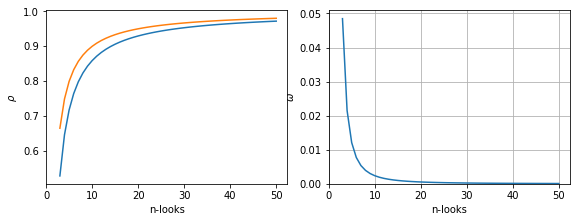

In [9]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
fig.tight_layout()
nlooks = np.arange(3, 51)

for r in ['full', 'azimuthal']:
    p = ps[r]
    ax0.plot(nlooks, rho[r](p, nlooks, nlooks))
    ax0.set_xlim(0, None)
    ax0.set_xlabel("n-looks")
    ax0.set_ylabel(r"$\rho$")
    ax0.grid()
ax1.plot(nlooks, omega(p, nlooks, nlooks, 'full'))
ax1.set_xlim(0, None)
ax1.set_ylim(0, None)
ax1.set_xlabel("n-looks")
ax1.set_ylabel("$\omega$")
ax1.grid()

For the azimuthally symetric case the some elements are set to zero, as follow: 
$$
\begin{bmatrix}
    S_{00}       & 0 & S_{02}  \\
    0       & S_{11} & 0  \\
    S_{20}       & 0 & S_{22} 
\end{bmatrix}
$$
and this is the diagonally symetric case:
$$
\begin{bmatrix}
    S_{11}       & 0 & 0  \\
    0       & S_{22} & 0  \\
    0       & 0 & S_{33} 
\end{bmatrix}
$$

Below is the result when $p$ is set to ($3, \sqrt 3$ and $\sqrt 5$) for the full, diagonal and azimuthal cases resepectivally in each of the following equations:
$$
P_{estimated} = -2 \rho \ln Q,$$
$$Q = n (2 p \ln(2) + \ln(|X|) + \ln(|Y|) - 2 \ln(|X + Y|)),$$
$$\rho(p, m, n) = 1 - \frac{2 p^2 - 1}{6 p}  \left(\frac{1}{n} + \frac{1}{m} - \frac{1}{n + m}\right).$$
$$P_{theoretical} = \chi^2(p^2),$$


For this "correct" value of $p$, we get a very bad fit.

band: l 64/68 forest only


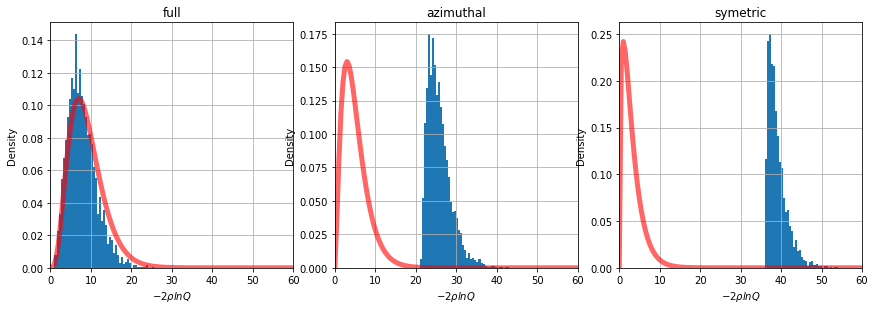

band: c 64/68 forest only


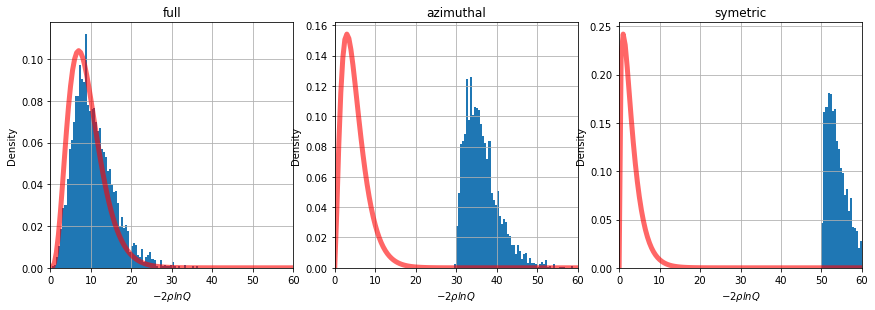

In [47]:
chi2_plots(ds, ((11, 11, 'l'), (15, 15, 'c')))

Below is the result for when $p$ is set to 3 for all cases (it should *not* be this value for the symetric cases), in the following equations:
$$
P_{estimated} = -2 \rho \ln Q,$$
$$Q = n (2 p \ln(2) + \ln(|X|) + \ln(|Y|) - 2 \ln(|X + Y|)),$$
$$\rho(p, m, n) = 1 - \frac{2 p^2 - 1}{6 p}  \left(\frac{1}{n} + \frac{1}{m} - \frac{1}{n + m}\right).$$

However, for the theoretical:
$$P_{theoretical} = \chi^2(p^2),$$
$p$ is set to the "correct" values ($3, \sqrt 3$ and $\sqrt 5$) for the full, diagonal and azimuthal cases resepectivally.

For this wrong value of $p$, we get a fairly good fit

band: l 64/68 forest only


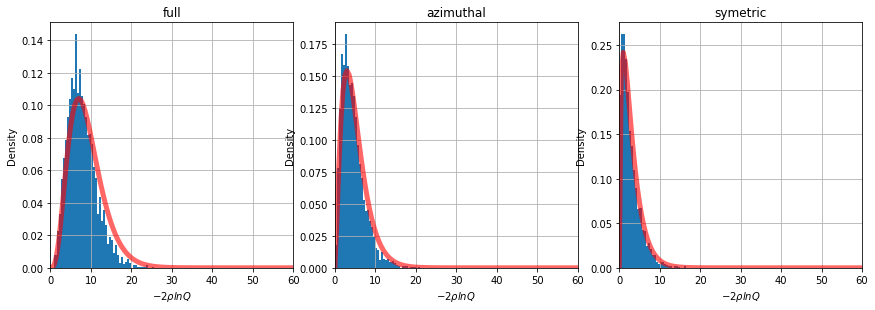

band: c 64/68 forest only


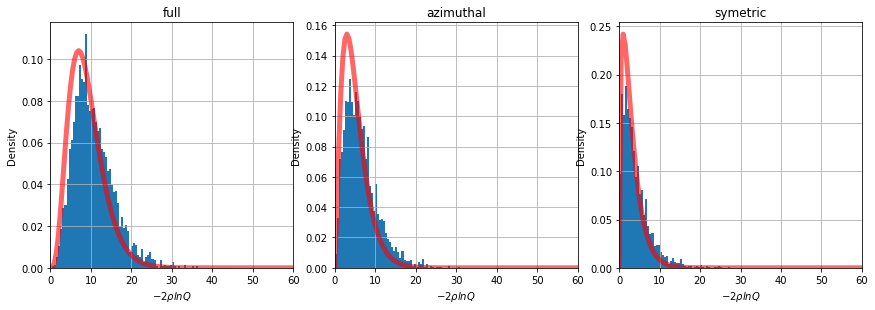

In [49]:
chi2_plots(ds, ((11, 11, 'l'), (15, 15, 'c')))

## Averaged array

In [ ]:
skip = 10
ds_roll = ds.rolling(x=skip, min_periods=1).mean().rolling(y=skip, min_periods=1).mean()
#np.flip(np.abs(ds_ave), axis=0).plot(vmax=0.2)
slicer = slice(None,None,skip)
ds_roll = ds_roll.isel(x=slicer, y=slicer)
mask_roll = mask.isel(x=slicer, y=slicer)
mask_forest_roll = mask_forest.isel(x=slicer, y=slicer)
np.flip(np.abs(ds_roll['fl063_c'].sel(i=0, j=0)), axis=0).plot(vmax=0.2);

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
np.abs(ds_roll['fl063_c'].sel(i=0, j=0)).plot(vmax=0.2, ax=ax1)
np.abs(ds['fl063_c'].sel(i=0, j=0)).plot(vmax=0.2, ax=ax2);

In [ ]:
plot_ENLs(ds_roll, mask_roll)

In [ ]:
sX = ds_roll['fl063_l'].where(mask_forest_roll)
sY = ds_roll['fl068_l'].where(mask_forest_roll)
mm, nn = 40, 40
plot_Qs(sX, sY, mm, nn, log=False)

In [ ]:
sym = 'symetric'
pp = ps[sym]
mm = mm = 30
sX = ds_roll['fl063_l'].where(mask_forest_roll)
sY = ds_roll['fl068_l'].where(mask_forest_roll)
chi2_est = chi2_estimated(sX, sY, mm, nn, pp, sym)
#np.flip(chi2_est, axis=1).plot()
#plt.show()
chi2_est.plot.hist(bins=100);

In [ ]:
np.concatenate(np.nan_to_num(sY))

In [ ]:
mask_forest_roll.plot()

## Bilinear Filter

In [ ]:
from scipy.ndimage.measurements import variance

def lee_filter_scalar(img, size):
    img = img.astype(np.float32)
    img_mean = cv2.bilateralFilter(img, 10, 5, 5)
    img_sqr_mean = cv2.bilateralFilter(img**2, 10, 5, 5)
    img_variance = img_sqr_mean - img_mean**2
    
    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

def lee_filter(da, size=7):
    vr = lee_filter_scalar(da.real.values, size)
    if np.any(da.imag.values):
        vi = lee_filter_scalar(da.imag.values, size)
    else:
        vi = np.zeros(vr.shape)
    return vr + 1j*vi

def apply_func(dataset, func):
    d = dataset
    ds_filt = xr.zeros_like(d).load()
    vijs = itertools.product(d.variables, d.i.values, d.j.values)
    for v, i, j in vijs:
        ds_filt[v].loc[dict(i=i, j=j)] = func(d[v].isel(i=i, j=j))
        print(v, i, j)
        #break
    return ds_filt

#ds_filt_lee = apply_func(ds, lee_filter)
#ds_filt_lee = ds_filt_lee.compute()

In [ ]:
ds_roll['fl063_l'].sel(i=0,j=0).real.plot(vmax=0.1)

In [ ]:
hh = np.complex128(ds['fl063_c'].sel(x=110,y=100,i=0,j=0).values)
vv = np.complex128(ds['fl063_c'].sel(x=110,y=100,i=2,j=2).values)

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(9,9))
i, j = 2, 0
ax1.imshow(np.angle(ds.fl063_c.isel(i=i,j=j)))
ax2.imshow(np.angle(ds_ave.fl063_c.isel(i=i,j=j)))

In [ ]:
im = ds.fl063_c.sel(i=0, j=0).values.astype(np.float32)

im_filt = cv2.bilateralFilter(ds.fl063_c.sel(i=0, j=0).values.astype(np.float32), 
                              10, 5, 5)
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

ax1.imshow(10*np.log10(im_filt), vmin=-20, vmax=-5, cmap='plasma')
ax1.set_xlim(0, 300)
ax1.set_ylim(0, 300);

ax2.imshow(10*np.log10(im), vmin=-20, vmax=-5, cmap='plasma')
ax2.set_xlim(0, 300)
ax2.set_ylim(0, 300);
plt.show()

plot_ENLs(ds_filt_lee, mask_all)

chi2_plots(ds_filt_lee, ((80, 80, 'l'), (80, 80, 'c')))

band_paras = (('c', 14, 14), ('l', 10, 10))
for b, mm, nn in band_paras:
    #for t1, t2 in itertools.combinations((3, 4, 5, 8), 2):
    for t1, t2 in [(3, 4), (4, 5), (5, 8)]:
        f1, f2 = f'fl06{t1}_{b}', f'fl06{t2}_{b}'
        chi2_est = chi2_estimated(ds[f1], ds[f2], mm, nn, 3, 'full')
        #np.flip(chi2_est > 40, axis=1).plot(cmap='gray', figsize=(8, 6));
        np.flip(chi2_est, axis=1).plot(cmap='gray', vmin=0, vmax=50, figsize=(8, 6));
        plt.title(f'{f1} / {f2}')

## Edge Aligned Filter

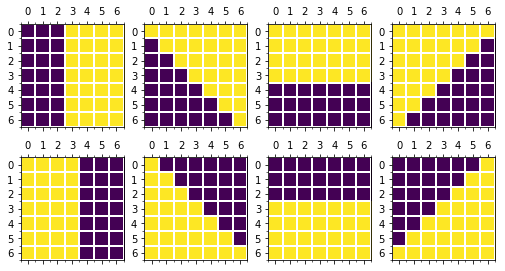

In [51]:
edge_masks = {
    0: np.array([[-1, 0, 1], 
                 [-1, 0, 1], 
                 [-1, 0, 1]]),
    1: np.array([[0, 1, 1], 
                 [-1, 0, 1], 
                 [-1, -1, 0]]),
    2: np.array([[1, 1, 1], 
                 [0, 0, 0], 
                 [-1, -1, -1]]),
    3: np.array([[1, 1, 0], 
                 [1, 0, -1], 
                 [0, -1, -1]])
}
edge_masks[4] = -1*edge_masks[0] 
edge_masks[5] = -1*edge_masks[1] 
edge_masks[6] = -1*edge_masks[2] 
edge_masks[7] = -1*edge_masks[3] 
edge_masks[8] = np.array([[0, 0, 0], 
                          [0, 1, 0], 
                          [0, 0, 0]])

edge_masks_np = np.stack([em for k, em in edge_masks.items()])

centre_mask = np.array([[0, 0, 0], 
                        [0, 1, 0], 
                        [0, 0, 0]])

def edge_window(func):
    return np.fromfunction(func, (7, 7), dtype=int)

edge_windows = {
    0: edge_window(lambda i, j: j >= 3),
    1: edge_window(lambda i, j: i - 1 < j),
    2: edge_window(lambda i, j: i <= 3),
    3: edge_window(lambda i, j: 6 - i >= j),
    4: edge_window(lambda i, j: j <= 3),
    5: edge_window(lambda i, j: i > j - 1),
    6: edge_window(lambda i, j: i >= 3),
    7: edge_window(lambda i, j: i >= 6 - j)
}

shift = {0: (-1,  0),  4: ( 1,  0), 
         1: (-1, -1),  5: ( 1,  1), 
         2: ( 0, -1),  6: ( 0,  1),
         3: ( 1, -1),  7: (-1,  1),
         8: ( 0,  0)}

fig, axs = plt.subplots(figsize=(8.5, 4.5), nrows=2, ncols=4);
axs = axs.ravel()
for i, ax in enumerate(axs): 
    ax.matshow(edge_windows[i])
    ax.set_xticks(np.arange(-.5, 7, 1), minor=True);
    ax.set_yticks(np.arange(-.5, 7, 1), minor=True);
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

In [52]:
shift_direction = 1

def direction_masks(cov_matrix):
    ds_eye = cov_matrix.sel(i=[0, 1, 2], j=[0, 1, 2,]).mean(dim=('i', 'j'))
    r = ds_eye.rolling(x=3, min_periods=1).construct('wx', stride=2).\
                  rolling(y=3, min_periods=1).construct('wy', stride=2)

    def amasks(dataset, mask, axis):
        return np.mean(dataset*edge_masks_np[mask], axis=axis)

    def apply_mask(mask):
        xs, ys = shift[mask]
        rs = r.copy()
        rs = rs.shift(x=shift_direction*xs, y=shift_direction*ys)
        return xr.apply_ufunc(amasks, rs, input_core_dims=[['wx', 'wy']], 
                                      kwargs={'axis':(2, 3), 'mask': mask})

    masks_applied = [apply_mask(m).values for m in range(9)]
    masks_applied = xr.DataArray(np.stack(masks_applied), dims=('mask', 'x', 'y'))
    # difference
    masks_applied = np.abs(masks_applied.sel(mask=slice(0, 8)) - masks_applied.sel(mask=8))
    # ratio
    #masks_applied = np.abs(masks_applied.sel(mask=slice(0, 8)) * masks_applied.sel(mask=8))
    return masks_applied

def edge_aligned_filter_b(cov_matrix):
    ma = direction_masks(cov_matrix)
    select = (ma == ma.min(dim='mask'))
    for i, j in itertools.product(cov_matrix.i.values, cov_matrix.j.values):
        r7 = cov_matrix.sel(i=0, j=0).rolling(x=7, min_periods=1).\
             construct('wx', stride=2).rolling(y=7, min_periods=1).construct('wy', stride=2)

        def local_stats_filter(y, axis):
            """
            Returns b + 1j*y_bar: b and y together in as a complex number
            """
            σv2 = 0.5**2
            y_bar = np.mean(y, axis=axis)
            var_y = np.var(y, axis=axis)
            var_x = (var_y - y_bar**2*σv2) / (1 + σv2)
            b = var_x / var_y
            return b + 1j*y_bar
        
        def amasks(dataset, mask, axis):
            return local_stats_filter(dataset*edge_windows[mask], axis) 

        def apply_mask(mask):
            return xr.apply_ufunc(amasks, r7, input_core_dims=[['wx', 'wy']], 
                                          kwargs={'axis':(2, 3), 'mask': mask})

        windows_applied = [apply_mask(m).values for m in range(8)]
        windows_applied = xr.DataArray(np.stack(windows_applied), dims=('mask', 'x', 'y'))
        res = windows_applied.where(select).sum(dim='mask')
        bs = res.real
        var_y = res.imag
        yield i, j, bs, var_y
        
def apply_func(dataset):
    ds_org = dataset.sel(x=slice(None, None, 2), y=slice(None, None, 2))
    ds_b = xr.zeros_like(ds_org.real).load()
    ds_y_bar = xr.zeros_like(ds_org.real).load()
    for name in dataset.variables:
        for i, j, b, y_bar in edge_aligned_filter_b(dataset[name]):
            ds_b[name].loc[dict(i=i, j=j)] = b
            ds_y_bar[name].loc[dict(i=i, j=j)] = y_bar
            print(name, i, j)
            #break
        #break
    return ds_org, ds_b, ds_y_bar

ds_org, ds_bs, ds_y_bar = apply_func(ds)
ds_edge_aligned_filt = ds_y_bar + ds_bs*(ds_org - ds_y_bar)

fl063_c 0 0
fl063_c 0 1
fl063_c 0 2
fl063_c 1 0
fl063_c 1 1
fl063_c 1 2
fl063_c 2 0
fl063_c 2 1
fl063_c 2 2
fl063_l 0 0
fl063_l 0 1
fl063_l 0 2
fl063_l 1 0
fl063_l 1 1
fl063_l 1 2
fl063_l 2 0
fl063_l 2 1
fl063_l 2 2
fl064_c 0 0
fl064_c 0 1
fl064_c 0 2
fl064_c 1 0
fl064_c 1 1
fl064_c 1 2
fl064_c 2 0
fl064_c 2 1
fl064_c 2 2
fl064_l 0 0
fl064_l 0 1
fl064_l 0 2
fl064_l 1 0
fl064_l 1 1
fl064_l 1 2
fl064_l 2 0
fl064_l 2 1
fl064_l 2 2
fl065_c 0 0
fl065_c 0 1
fl065_c 0 2
fl065_c 1 0
fl065_c 1 1
fl065_c 1 2
fl065_c 2 0
fl065_c 2 1
fl065_c 2 2
fl065_l 0 0
fl065_l 0 1
fl065_l 0 2
fl065_l 1 0
fl065_l 1 1
fl065_l 1 2
fl065_l 2 0
fl065_l 2 1
fl065_l 2 2
fl068_c 0 0
fl068_c 0 1
fl068_c 0 2
fl068_c 1 0
fl068_c 1 1
fl068_c 1 2
fl068_c 2 0
fl068_c 2 1
fl068_c 2 2
fl068_l 0 0
fl068_l 0 1
fl068_l 0 2
fl068_l 1 0
fl068_l 1 1
fl068_l 1 2
fl068_l 2 0
fl068_l 2 1
fl068_l 2 2


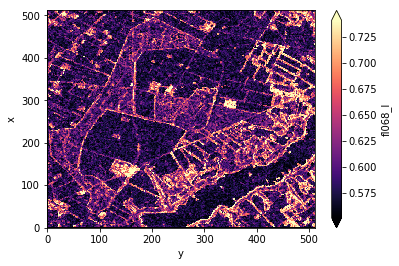

In [53]:
ds_bs.fl068_l.sel(i=0,j=0).plot(robust=True, cmap='magma')

In [59]:
ds_edge_aligned_filt.sel(i=1, j=0)

<xarray.Dataset>
Dimensions:  (x: 512, y: 512)
Dimensions without coordinates: x, y
Data variables:
    fl063_c  (x, y) complex128 0j ... (0.01593926896732341-0.0014213114533737886j)
    fl063_l  (x, y) complex128 0j ... (0.10139988000817182-0.003874772337525138j)
    fl064_c  (x, y) complex128 0j ... (0.01954551528375119-0.0007222885258477554j)
    fl064_l  (x, y) complex128 0j ... (0.0777603438076852-0.0003440651406763831j)
    fl065_c  (x, y) complex128 0j ... (0.030300263149094078-0.0008380398470898346j)
    fl065_l  (x, y) complex128 0j ... (0.043142711864519206+0.010902582695272247j)
    fl068_c  (x, y) complex128 0j ... (0.03273904766592636-0.001411839913443582j)
    fl068_l  (x, y) complex128 0j ... (0.06550436585476307-0.020631533105215347j)

In [ ]:
slicer = slice(None, None, 2)
mask_roll = mask.isel(x=slicer, y=slicer)
plot_ENLs(ds_edge_aligned_filt, mask_roll)

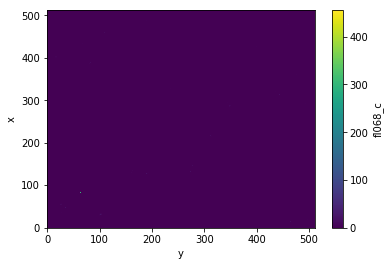

In [66]:
ds_edge_aligned_filt[cm_name].sel(i=0,j=0).real.plot()

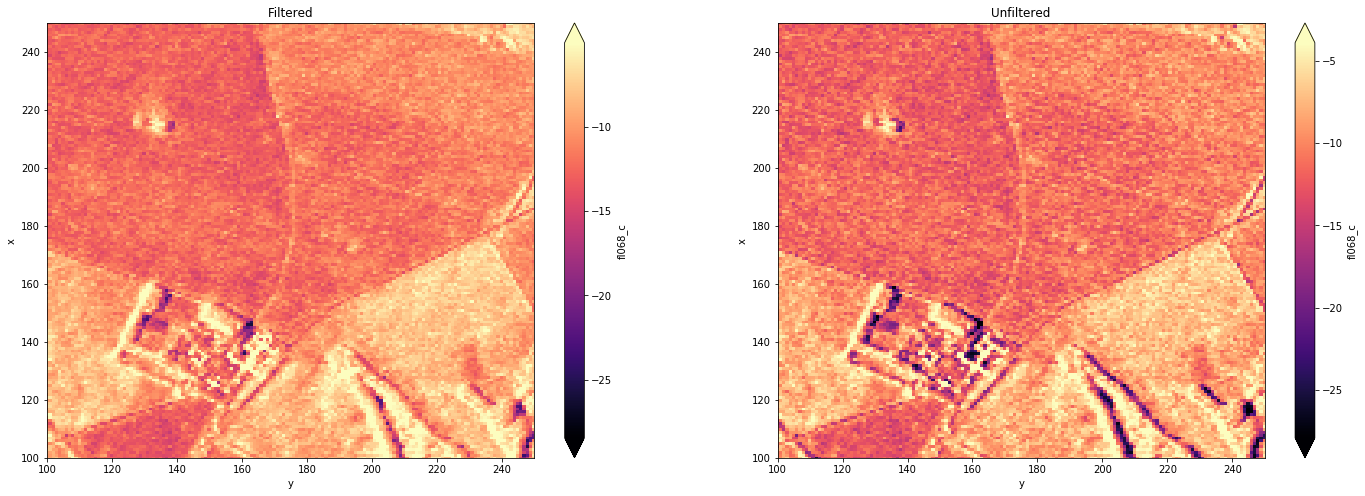

In [68]:
#mask_labels = masks_applied.dropna(dim=('mask'), how='all').dropna(dim=('x'), how='all').dropna(dim=('y'), how='all').argmax(dim='mask', skipna=True)
#plt.figure(figsize=(10, 10))
#np.flip(mask_labels, axis=0).plot(cmap='Set1');
#plt.show()
cm_name, ii, jj = 'fl068_c', 0, 0

fig, (ax0, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(24, 8))
#fig.suptitle(f'{cm_name}, {ii}, {jj}')
#xmin, xmax, ymin, ymax = None, None, None, None
#xmin, xmax, ymin, ymax = 0, 440, 0, 440
#xmin, xmax, ymin, ymax = 512 - 100, 512, 0, 100
xmin, xmax, ymin, ymax = 100, 250, 100, 250
#xmin, xmax, ymin, ymax = 300, 400, 300, 400

res = ds_edge_aligned_filt[cm_name].sel(i=ii, j=jj).real
(10*np.log10(res)).plot(robust=True, cmap='magma', ax=ax0)
ax0.set_xlim(xmin, xmax)
ax0.set_ylim(ymin, ymax)
ax0.set_title('Filtered')

res = ds[cm_name].sel(i=ii, j=jj, x=slice(None, None, 2), y=slice(None, None, 2)).real
(10*np.log10(res)).plot(robust=True, cmap='magma', ax=ax1)
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax);
ax1.set_title('Unfiltered');

In [ ]:
plt.figure(figsize=(10, 10))
mask_labels.fl063_c.sel(i=0, j=0).rolling(x=3, min_periods=3).construct('wx', stride=1).rolling(y=3, min_periods=3).construct('wy', stride=1)

def select(arr, mask, axis):
    arr[1,1] = np.nan
    return np.mean(dataset*edge_masks_np[mask], axis=axis)

def apply_mask(mask):
    return xr.apply_ufunc(amasks, r, input_core_dims=[['wx', 'wy']], 
                                kwargs={'axis':(2,3), 'mask': mask})

## Toolbox for SAR

https://www.orfeo-toolbox.org/CookBook/index_TOC.html

In [ ]:
#!pwd